In [29]:
import asyncio
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain.prompts import ChatPromptTemplate

class SummarizeState(dict):
    docs: list
    summaries: list

llm = ChatOllama(
    model="gemma3:1b-it-qat",
    temperature=0,
)

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that summarizes documents into the core of short sentences in indonesian language."),
    ("human", "Summarize this document in indonesian language:\n\n{doc}")
])

async def summarize_worker(doc: str):
    chain = prompt | llm
    resp = await chain.ainvoke({"doc": doc})
    return resp.content

In [30]:
def splitter(state: SummarizeState):
    return {"docs": state["docs"]}

async def parallel_summarizer(state: SummarizeState):
    tasks = [summarize_worker(doc) for doc in state["docs"]]
    results = await asyncio.gather(*tasks)
    return {"summaries": results}

def aggregator(state: SummarizeState):
    combined = "\n\n".join(state["summaries"])
    return {"final_report": combined}

graph = StateGraph(SummarizeState)
graph.add_node("split", splitter)
graph.add_node("summarize", parallel_summarizer)
graph.add_node("aggregate", aggregator)

graph.set_entry_point("split")
graph.add_edge("split", "summarize")
graph.add_edge("summarize", "aggregate")
graph.add_edge("aggregate", END)

app = graph.compile()

In [31]:
def load_documents(path="documents.txt"):
    docs = []
    with open(path, "r") as f:
        content = f.read().split("=== DOC")
        for c in content:
            if c.strip():
                lines = c.strip().splitlines()
                if len(lines) > 1:
                    text_only = " ".join(lines[1:]).strip()
                else:
                    text_only = c.strip()
                docs.append(text_only)
    return docs


docs = load_documents("documents.txt")
result = await app.ainvoke({"docs": docs})

/home/aliffatur/miniconda3/envs/langgraph_env/lib/python3.11/site-packages/httpx/_urlparse.py:223: RuntimeWarning: coroutine 'Pregel.ainvoke' was never awaited
  if any(char.isascii() and not char.isprintable() for char in url):


In [32]:
result

{'docs': ['Pertanian modern mulai memanfaatkan teknologi sensor dan drone untuk memantau kondisi lahan, kelembaban tanah, dan kesehatan tanaman secara real time.',
  'Pariwisata di Indonesia mengalami perkembangan pesat berkat promosi digital dan media sosial, yang membantu menarik wisatawan lokal maupun mancanegara.',
  'Pendidikan jarak jauh semakin populer, terutama setelah pandemi. Platform e-learning membuat akses pendidikan menjadi lebih inklusif.',
  'Transportasi publik di kota besar terus ditingkatkan dengan penggunaan sistem pembayaran digital dan integrasi antar moda.',
  'Kesehatan mental kini menjadi perhatian utama, dengan meningkatnya kesadaran masyarakat terhadap pentingnya konseling dan dukungan psikologis.'],
 'summaries': ['Teknologi sensor dan drone digunakan untuk memantau kondisi lahan, kelembaban tanah, dan kesehatan tanaman secara real time dalam pertanian modern.',
  'Pariwisata di Indonesia semakin berkembang karena promosi digital dan media sosial, menarik wi

In [35]:
mermaid_code = app.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	split(split)
	summarize(summarize)
	aggregate(aggregate)
	__end__([<p>__end__</p>]):::last
	__start__ --> split;
	split --> summarize;
	summarize --> aggregate;
	aggregate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



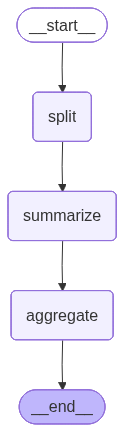

In [ ]:
from IPython.display import Image, display

png_data = app.get_graph().draw_mermaid_png()
display(Image(png_data))

In [39]:
from IPython.display import HTML

mermaid_code = """
<div class="mermaid">
graph TD;
    __start__([__start__]):::first
    split(split)
    subgraph PARALLEL[Parallel Summarize Workers]
        summarize1(summarize 1)
        summarize2(summarize 2)
        summarize3(summarize 3)
    end
    aggregate(aggregate)
    __end__([__end__]):::last

    __start__ --> split;
    split --> summarize1;
    split --> summarize2;
    split --> summarize3;
    summarize1 --> aggregate;
    summarize2 --> aggregate;
    summarize3 --> aggregate;
    aggregate --> __end__;
</div>

<script type="module">
  import mermaid from "https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.esm.min.mjs";
  mermaid.initialize({ startOnLoad: true });
</script>
"""

HTML(mermaid_code)


user Query -> lempar llm untuk keyword search -> api tavily -> agregator -> chatbot summarizer -> output